## センチメント分析の実装

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import torch
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

### データセット

#### データセットの読み込み

In [3]:
import pandas as pd
train_df=pd.read_csv('/media/lyuzeyu_hdd/css_nlp/notebook/Data/train.csv')
val_df=pd.read_csv('/media/lyuzeyu_hdd/css_nlp/notebook/Data/valid.csv')
test_df=pd.read_csv('/media/lyuzeyu_hdd/css_nlp/notebook/Data/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/media/lyuzeyu_hdd/css_nlp/notebook/Data/train.csv'

#### サンプルデータの確認

取得したデータセットの中身を確認します。



In [4]:
train_df.head()

,sentence,label,user_id,datetime
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,1,1,2012/7/31 23:48
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな〜 と立ち止まる帰り道。チャリなし生活も...,0,1,2012/8/2 23:09
2,眠い、眠れない。,1,1,2012/8/8 1:36
3,表情筋が衰えてきてる。まずいな…,1,1,2012/8/11 1:20
4,やばい。おもろいな〜思ってみてみた「シャレードがいっぱい」。よすぎるやん。,0,1,2012/8/16 23:50


<Axes: title={'center': 'Train Dataset'}, ylabel='label'>

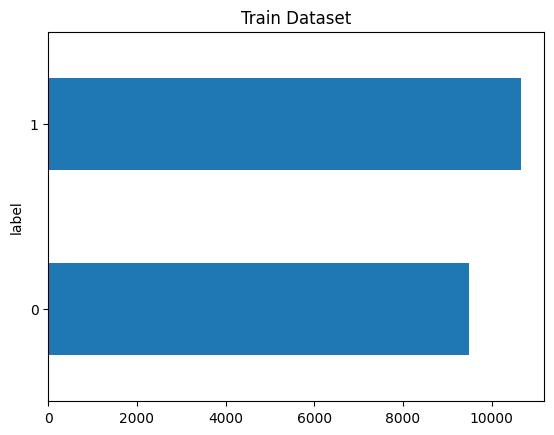

In [5]:
import matplotlib.pyplot as plt
train_df["label"].value_counts(ascending=True).plot(kind="barh", title="Train Dataset")

#### テキストの確認

Transformerモデルは、最大コンテキストサイズ(maximum context size)と呼ばれる最大入力系列長があります。

モデルのコンテキストサイズより長いテキストは切り捨てる必要があり、切り捨てたテキストに重要な情報が含まれている場合、性能の低下につながることがあります。

In [6]:
train_df["text_length"]=train_df["sentence"].str.len()

<Axes: title={'center': 'text_length'}, xlabel='label'>

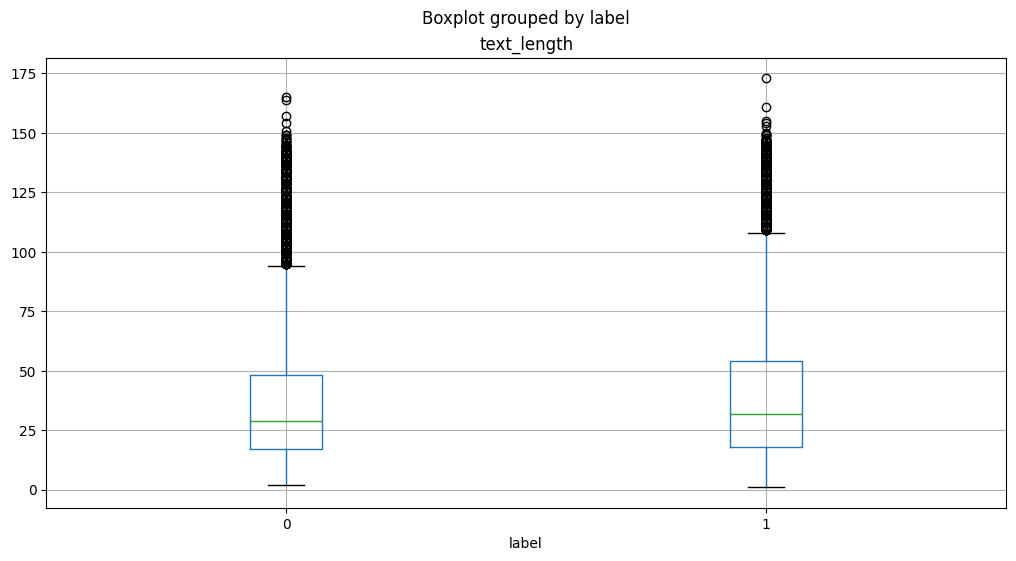

In [7]:
train_df.boxplot(column="text_length", by="label", figsize=(12, 6))


### トークン化

コンピュータは、入力として生の文字列を受け取ることができません。その代わりに、テキストがトークン化され、数値ベクトルとしてエンコードされていることが想定しています。

トークン化は、文字列をモデルで使用される最小単位に分解するステップです。

Transformerライブラリー は便利なAutoTokenizerクラスを提供しており、事前学習済みモデルに関連つけられたトークナイザーを素早く使用することができます。

#### トークナイザの動作確認


tokenizerテキストを数値形式（トークン）に変換します。
- 入力テキストをトークンに分割します
- 特殊トークンが自動的に付加されます
- トークンをトークンIDに変換します

In [8]:
from transformers import AutoTokenizer
model_ckpt = "tohoku-nlp/bert-base-japanese"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [9]:
train_df["sentence"][0]

'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…'

In [10]:
sample_text_encoded = tokenizer(train_df["sentence"][0])
sample_text_encoded

{'input_ids': [2, 3937, 28517, 4662, 15, 16, 3318, 12272, 640, 8, 1131, 28479, 31, 40, 2949, 7, 12, 1549, 5, 7, 143, 143, 143, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

結果にinput_idsとattention_maskが含まれます。

- input_ids: 数字にエンコードされたトークン
- attention_mask: モデルで有効なトークンかどうかを判別するためのマスクです。無効なトークン（例えば、PADなど）に対しては、attention_maskを
として処理します。

各batchにおいて、入力系列はbatch内最大系列長までpaddingされます。

 ![](./Figure/attention_id.png)


トークナイザの結果は数字にエンコードされているため、トークン文字列を得るには、convert_ids_to_tokensを用います。

文の開始が[CLS]、文の終了が[SEP]という特殊なトークンとなっています。

In [11]:
tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded.input_ids)
print(tokens)

['[CLS]', 'ぼ', '##け', '##っと', 'し', 'て', 'たら', 'こんな', '時間', '。', 'チャ', '##リ', 'ある', 'から', '食べ', 'に', 'で', 'たい', 'の', 'に', '.', '.', '.', '[SEP]']


#### データセット全体のトークン化



In [12]:
import re
from tqdm import tqdm
from transformers import AutoTokenizer

def create_dataset(df, pad_size, auto_tokenizer):
    tokenizer = AutoTokenizer.from_pretrained(auto_tokenizer)
    df["text"] = df["sentence"].astype(str)
    df["label"] = df["label"].astype(int)
    contents = []
    for index, rows in tqdm(df.iterrows(), total=df.shape[0]):
        text = rows["text"]
        label = rows["label"]
        # Remove URLs and mentions
        text = re.sub(r"(?:\@|https?\://)\S+\b", "", text)
        # Tokenize the text
        token = tokenizer(text, padding='max_length', truncation=True, max_length=pad_size, return_tensors="np")
        # Extract token ids and attention mask
        token_ids = token['input_ids'][0]
        attention_mask = token['attention_mask'][0]
        # Calculate sequence length (excluding padding)
        seq_len = sum(attention_mask)  # Sequence length is the sum of the attention mask
        contents.append((token_ids, int(label), seq_len, attention_mask))
    return contents


In [13]:
train=create_dataset(df=train_df, pad_size=128, auto_tokenizer=model_ckpt)
val=create_dataset(df=val_df, pad_size=128, auto_tokenizer=model_ckpt)
test=create_dataset(df=test_df, pad_size=128, auto_tokenizer=model_ckpt)

100%|██████████| 1781/1781 [00:00<00:00, 5413.41it/s]


In [14]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, device):
        self.data = data
        self.device = device
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        token_ids, label, seq_len, mask = self.data[idx]
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long).to(self.device),
            'label': torch.tensor(label, dtype=torch.long).to(self.device),
            'seq_len': torch.tensor(seq_len, dtype=torch.long).to(self.device),
            'attention_mask': torch.tensor(mask, dtype=torch.long).to(self.device)
        }

In [15]:
train_dataset = CustomDataset(train, device=device)
val_dataset = CustomDataset(val, device=device)
test_dataset = CustomDataset(test, device=device)

In [17]:
for i, batch in enumerate(train_dataset):
    print(f"Batch {i + 1}")
    print("Input IDs:\n", batch['input_ids'])
    print("Labels:\n", batch['label'])
    print("Attention Mask:\n", batch['attention_mask'])
    print("Sequence Lengths:\n", batch['seq_len'])
    
    # Break after a few iterations
    if i == 2:  # Inspect first 3 batches
        break

Batch 1
Input IDs:
 tensor([    2,  3937, 28517,  4662,    15,    16,  3318, 12272,   640,     8,
         1131, 28479,    31,    40,  2949,     7,    12,  1549,     5,     7,
          143,   143,   143,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,  

### 分類器の実装


#### AutoModelForSequenceClassificationのファインチューニング


transformerライブラリは、ファインチューニングのタスクに応じてAPIを提供しています。

分類タスクの場合、```AutoModel```の代わりに```AutoModelForSequenceClassification```を使用します。

```AutoModelForSequenceClassification```が事前学習済みモデルの出力の上に分類器ヘッドを持っており、モデルの設定がより簡単になります。

In [18]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

2025-01-06 18:41:25.363404: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 18:41:25.370428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 18:41:25.378352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 18:41:25.380722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 18:41:25.387228: I tensorflow/core/platform/cpu_feature_guar

In [19]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [22]:
inputs = tokenizer("いい買い物でした.", return_tensors="pt") # pytorch tensorに変換するためにreturn_tensors="pt"を指定
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.1691, -0.1271]], device='cuda:0'), hidden_states=None, attentions=None)


#### 学習の準備

学習時に性能指標を与える必要があるため、それを関数化して定義しておきます。




In [23]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

学習を効率化するために、transformerライブラリの```Trainer``` APIを使用します。

```Trainer```クラスを初期化する際には、```TrainingArguments```という訓練に関する様々な設定値の集合を引数に与えることで、訓練の設定に関する細かい調整が可能です。

In [25]:

from transformers import TrainingArguments

batch_size = 16
logging_steps = len(train_dataset) // batch_size
model_name = "sample-text-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

/home/lvzeyu/anaconda3/envs/nlp/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Trainerクラスで実行します。

結果を確認すると、特徴ベースのアプローチよりも精度が改善されることがわかります。

In [31]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)


/tmp/ipykernel_547429/2159861020.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [32]:
trainer.train()

/home/lvzeyu/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.234931,0.901741,0.901751
2,0.252000,0.248944,0.902985,0.902999


/home/lvzeyu/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/lvzeyu/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/lvzeyu/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/lvzeyu/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was a

TrainOutput(global_step=1260, training_loss=0.2519285740242118, metrics={'train_runtime': 239.7328, 'train_samples_per_second': 168.095, 'train_steps_per_second': 5.256, 'total_flos': 2650712327224320.0, 'train_loss': 0.2519285740242118, 'epoch': 2.0})

### 学習済みモデルの使用

#### モデル精度の検証

学習済みのモデルを他のデータセットに適用します。



In [33]:
preds_output = trainer.predict(test_dataset)

/home/lvzeyu/anaconda3/envs/nlp/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [34]:
test_dataset.data[0]

(array([    2,  6678, 23573,     5,  2062,  1466,    14, 12006,    10,
            5,    12,     6,  4794,    28,   737,    73,  5228, 28611,
            7, 10427,    34,   859,     5,   174,     5,  1305,    14,
        12283, 12375,     8, 12272,    45,     9,  3188,    80,     8,
            3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

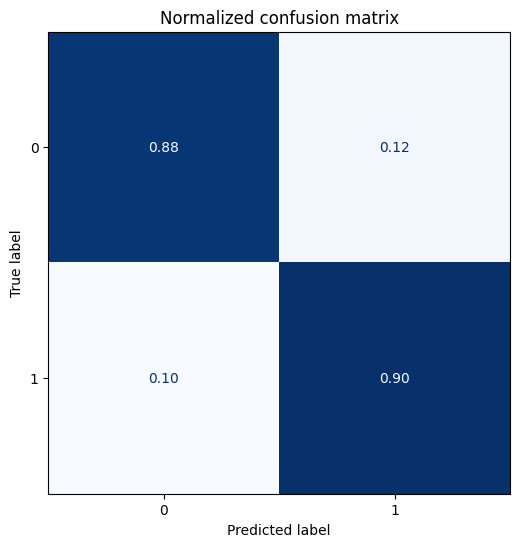

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_true= test_df["label"].astype(int)
labels = [0,1]

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_true, labels)

#### モデル保存



In [37]:
trainer.save_model(f"./Data/sample-text-classification-bert")

#### 学習済みモデルの読み込み


In [38]:
new_tokenizer = AutoTokenizer\
    .from_pretrained(f"./Data/sample-text-classification-bert")

new_model = (AutoModelForSequenceClassification
    .from_pretrained(f"./Data/sample-text-classification-bert")
    .to(device))

サンプルテキストで推論の結果を確認します。



In [39]:
def id2label(x):
    label_dict={0:"positive",1:"neutral",2:"negative"}
    return label_dict[x]

In [40]:
text1="this week is not going as i had hoped"
text2="awe i love you too!!!! 1 am here i miss you"

In [41]:

inputs = new_tokenizer(text1, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
outputs.logits

y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
y_preds

array([0])

In [43]:
wrime = pd.read_csv('/media/lyuzeyu_hdd/css_nlp/notebook/Data/wrime-ver1.tsv', sep='\t')


In [46]:
wrime["Train/Dev/Test"].value_counts()

Train/Dev/Test
train    40000
test      2000
dev       1200
Name: count, dtype: int64